In [47]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from statsmodels import api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, Input, Flatten
from keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Dense, TimeDistributed
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption, calculate_datetime_diffs
from tools import to_timeseries, get_task2
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [48]:
SEQUENCE_SIZE = 128
BATCH_SIZE = 1024

# Data

In [49]:
def get_task2(y):
    n = y.shape[0]
    data = np.zeros((n, 3))

    for i in range(n):
        data[i] = (y[i].mean(), y[i].max(), y[i].min())
        
    return data

In [92]:
dataset = load_household_power_consumption(hour_one_hot=True)
dataset['active_power'] = dataset['active_power'].rolling(window=12).mean()
dataset['active_power_cos'] = np.cos(dataset['active_power'])
# dataset['active_power_mean'] = dataset['active_power'].rolling(window=12).mean()
# dataset['active_power_std'] = dataset['active_power'].rolling(window=12).std()
dataset['active_power_diff1'] = dataset['active_power'].diff(-1)
# dataset['active_power_diff2'] = dataset['active_power'].diff(-2)
# dataset['active_power_diff3'] = dataset['active_power'].diff(-3)
# dataset['active_power_diff4'] = dataset['active_power'].diff(-4)
# dataset['active_power_diff5'] = dataset['active_power'].diff(-5)

dataset['active_power2'] = dataset['active_power']**2
dataset['active_power3'] = dataset['active_power']**3
dataset['active_power4'] = dataset['active_power']**4
# dataset['active_power5'] = dataset['active_power']**5
# dataset['active_power6'] = dataset['active_power']**6
# dataset['active_power7'] = dataset['active_power']**7
# dataset['active_power8'] = dataset['active_power']**8
# dataset['active_power9'] = dataset['active_power']**9
dataset = dataset.dropna()

data_x, data_y = split_x_y(dataset, SEQUENCE_SIZE)
diff_x, diff_y = split_x_y(calculate_datetime_diffs(dataset), SEQUENCE_SIZE)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x, diff_x, t=SEQUENCE_SIZE), 
    to_timeseries(data_y, diff_y, t=SEQUENCE_SIZE), 
    train_ratio=0.8)

train_y2 = get_task2(train_y)
test_y2 =  get_task2(test_y)

# train_y = pad_sequences(train_y.reshape(-1, SEQUENCE_SIZE), maxlen=SEQ_Y_SIZE, truncating='post', dtype='float32')
# test_y = pad_sequences(test_y.reshape(-1, SEQUENCE_SIZE), maxlen=SEQ_Y_SIZE, truncating='post', dtype='float32')
# train_y = pad_sequences(train_y, SEQUENCE_SIZE, padding='post', dtype='float32').reshape(-1, SEQUENCE_SIZE, 1)
# test_y = pad_sequences(test_y, SEQUENCE_SIZE, padding='post', dtype='float32').reshape(-1, SEQUENCE_SIZE, 1)

display(dataset[['active_power', 'reactive_power', 'voltage', 'intensity', 'sub1',
                 'sub2', 'sub3', 'h_0', 'h_1', 'h_23']].head())


print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print()
print('diff_x:', diff_x.shape)
print('diff_y:', diff_y.shape)
print()
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print()
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-30 00:46:28,223 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,h_0,h_1,h_23
datetime,,,,,,,,,,
2010-10-27 13:51:00,0.531333,0.082,246.37,2.2,0.0,0.0,1.0,0,0,0
2010-10-27 13:52:00,0.525167,0.082,246.69,2.2,0.0,0.0,0.0,0,0,0
2010-10-27 13:53:00,0.522333,0.070,246.98,2.4,0.0,0.0,1.0,0,0,0
2010-10-27 13:54:00,0.530667,0.062,247.19,2.6,0.0,0.0,1.0,0,0,0
2010-10-27 13:55:00,0.538833,0.062,246.70,2.6,0.0,0.0,0.0,0,0,0


data_x: (43503, 36)
data_y: (43503, 1)

diff_x: (43503, 1)
diff_y: (43503, 1)

train_x: (33583, 128, 36)
train_y: (33583, 128, 1)

test_x: (8396, 128, 36)
test_y: (8396, 128, 1)


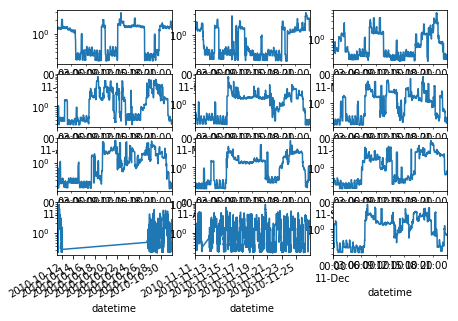

In [87]:
def show_active_power():
    fig, plots = subplots(4, 3)
    plots = plots.reshape(-1)
    fig.set_figheight(5)
    fig.set_figwidth(7)

    for i, p in enumerate(plots):
        i += 1
        dataset['active_power'].loc[f'2010-{i:02}'].plot(logy=True, ax=p)
        
show_active_power()

파란색 그래프가 보이면 안됩니다.
파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거


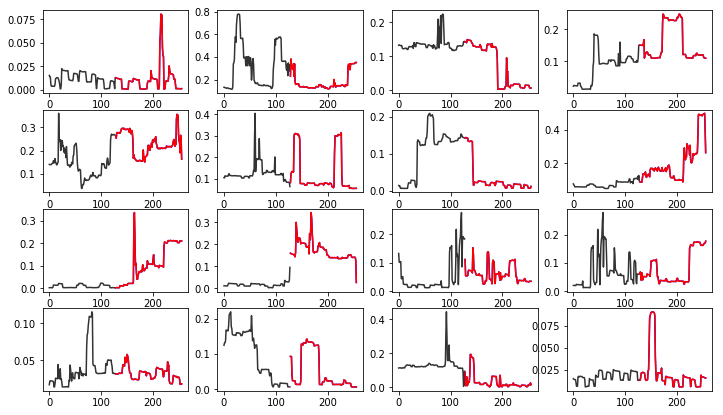

In [53]:
def vis_dataset(x, y):
    n = x.shape[0]
    seq_n = x.shape[1]
    
    fig, plots = pylab.subplots(4, 4)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    plots = plots.reshape(-1)

    for p in plots:
        idx = np.random.randint(0, n-SEQUENCE_SIZE)
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n*2)
        
        p.plot(x1, x[idx, :, 0], label='input', color='#333333')
        p.plot(x2, x[idx+SEQUENCE_SIZE, :, 0], label='output', color='blue')
        p.plot(x2, y[idx, :, 0], label='output', color='red')
        
print('파란색 그래프가 보이면 안됩니다.')
print('파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거')
vis_dataset(train_x, train_y)

# Models

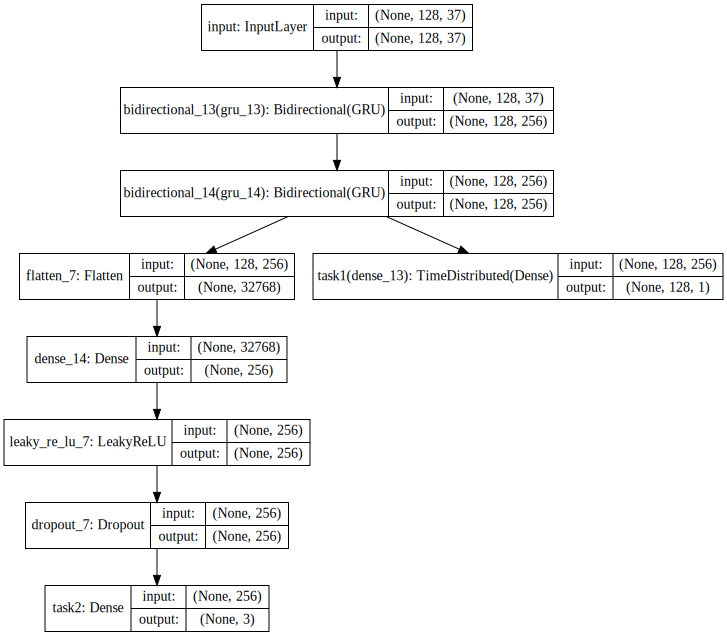

In [89]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1, l2, d1=64, d2=64, dout1=None, dout2=None, n_input=40):
    np.random.seed(0)
    input = Input(shape=(SEQUENCE_SIZE, n_input), name='input')
    rnn1 = Bidirectional(GRU(l1, return_sequences=True, recurrent_dropout=0.1))(input)
    rnn2 = Bidirectional(GRU(l1, return_sequences=True, recurrent_dropout=0.1))(rnn1)
    
    # Task 1
#     h1 = TimeDistributed(Dense(d1))(rnn2)
#     h1 = LeakyReLU()(h1)
#     if dout1:
#         h1 = Dropout(dout1)(h1)
    h1 = TimeDistributed(Dense(1), name='task1')(rnn2)
    
    # Task 2
    h2 = Flatten()(rnn2)
    h2 = Dense(d2)(h2)
    h2 = LeakyReLU()(h2)
    if dout2:
        h2 = Dropout(dout2)(h2)
    h2 = Dense(3, name='task2')(h2)
    
    model = Model(inputs=[input], outputs=[h1, h2])
    model.compile(optimizer=Adam(clipnorm=1.), 
                  loss={'task1': 'mse', 'task2': 'mse'},
                  loss_weights=[1., 0.3], 
                  metrics=[r2])
    return model

def create_model2(l1=64, l2=64, n_input=37):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(GRU(l1, return_sequences=True), input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(Bidirectional(GRU(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(clipnorm=1.), metrics=[r2])
    return model

model = create_model(128, 128, d1=256, d2=256, dout1=0.3, dout2=0.3, n_input=37)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [90]:
model = create_model(128, 128, d1=256, d2=256, dout1=0.3, dout2=0.3, n_input=37)
history = History()
model.fit(train_x, [train_y, train_y2], epochs=200, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, [test_y, test_y2]), callbacks=[history])

Train on 33583 samples, validate on 8396 samples
Epoch 1/200
29s - loss: 2.3519 - task1_loss: 0.0116 - task2_loss: 7.8010 - task1_r2: -6.1341e-02 - task2_r2: -3.7406e+02 - val_loss: 0.0163 - val_task1_loss: 0.0066 - val_task2_loss: 0.0323 - val_task1_r2: 0.1443 - val_task2_r2: -1.0112e+00
Epoch 2/200
26s - loss: 0.0157 - task1_loss: 0.0089 - task2_loss: 0.0227 - task1_r2: 0.1935 - task2_r2: -8.8345e-02 - val_loss: 0.0083 - val_task1_loss: 0.0063 - val_task2_loss: 0.0068 - val_task1_r2: 0.2095 - val_task2_r2: 0.4860
Epoch 3/200
26s - loss: 0.0119 - task1_loss: 0.0085 - task2_loss: 0.0113 - task1_r2: 0.2239 - task2_r2: 0.4608 - val_loss: 0.0084 - val_task1_loss: 0.0063 - val_task2_loss: 0.0068 - val_task1_r2: 0.1914 - val_task2_r2: 0.4872
Epoch 4/200
25s - loss: 0.0114 - task1_loss: 0.0084 - task2_loss: 0.0099 - task1_r2: 0.2318 - task2_r2: 0.5283 - val_loss: 0.0080 - val_task1_loss: 0.0061 - val_task2_loss: 0.0062 - val_task1_r2: 0.2331 - val_task2_r2: 0.5560
Epoch 5/200
27s - loss: 0.0

26s - loss: 0.0032 - task1_loss: 0.0026 - task2_loss: 0.0019 - task1_r2: 0.7585 - task2_r2: 0.9093 - val_loss: 0.0087 - val_task1_loss: 0.0068 - val_task2_loss: 0.0065 - val_task1_r2: 0.1025 - val_task2_r2: 0.5250
Epoch 38/200
26s - loss: 0.0031 - task1_loss: 0.0026 - task2_loss: 0.0018 - task1_r2: 0.7673 - task2_r2: 0.9149 - val_loss: 0.0086 - val_task1_loss: 0.0066 - val_task2_loss: 0.0064 - val_task1_r2: 0.1261 - val_task2_r2: 0.5420
Epoch 39/200
26s - loss: 0.0030 - task1_loss: 0.0025 - task2_loss: 0.0017 - task1_r2: 0.7712 - task2_r2: 0.9163 - val_loss: 0.0087 - val_task1_loss: 0.0067 - val_task2_loss: 0.0066 - val_task1_r2: 0.1259 - val_task2_r2: 0.5253
Epoch 40/200
26s - loss: 0.0029 - task1_loss: 0.0024 - task2_loss: 0.0017 - task1_r2: 0.7772 - task2_r2: 0.9210 - val_loss: 0.0090 - val_task1_loss: 0.0069 - val_task2_loss: 0.0069 - val_task1_r2: 0.0941 - val_task2_r2: 0.5028
Epoch 41/200


KeyboardInterrupt: 

# Evaluation

In [ ]:
%time eval_results = model.evaluate(test_x, [test_y, test_y2], batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

[2468] r^2: -43.68      
[2627] r^2: 0.03017     
[4578] r^2: -0.5381     
[1328] r^2: -1.247      
[4632] r^2: -25.96      
[6744] r^2: 0.03165     
[2265] r^2: -1.15       
[4455] r^2: 0.01891     
[6304] r^2: 0.07951     
[2602] r^2: -0.02149    
[2253] r^2: -1.248      
[2874] r^2: -104.6      
[5445] r^2: 0.1873      
[6342] r^2: -0.939      
[5049] r^2: -0.1958     
[2969] r^2: -24.67      


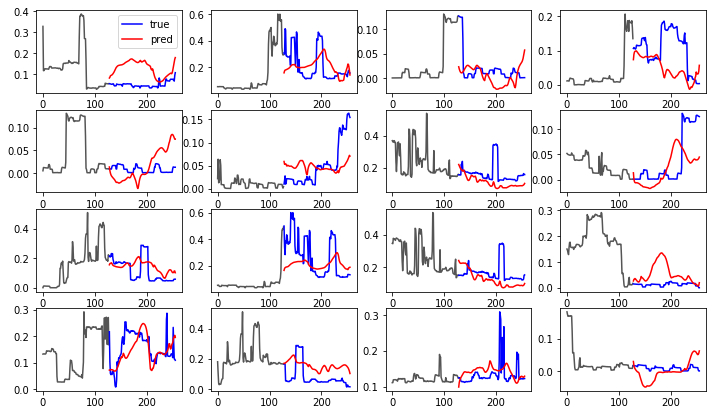

In [91]:
def vis_evaluate(model, test_x, test_y, batch=32):
    n = len(test_x)
    seq_n = test_x.shape[1]

    fig, plots = pylab.subplots(4, 4)
    plots = plots.reshape(-1)

    fig.set_figwidth(12)
    fig.set_figheight(7)

    for i, p in enumerate(plots):
        idx = np.random.randint(0, n)
        input_y = test_x[idx, :, 0]
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n * 2)

        true_y = test_y[idx]
        pred1, pred2 = model.predict(test_x[idx:idx + 1], batch_size=batch)

        score = r2_score(true_y.reshape(-1), pred1.reshape(-1))
        print(f'[{idx:<4}] r^2: {score:<12.4}')
        p.plot(x1, input_y, color='#555555')
        p.plot(x2, true_y, color='blue', label='true')
        p.plot(x2, pred1[0], color='red', label='pred')
        if i == 0:
            p.legend()


vis_evaluate(model, test_x, test_y, batch=BATCH_SIZE)